In [1]:
import json
from datetime import datetime, time, timedelta
import os
from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from colorama import Fore, Style
import sys  # For printing caught exceptions
import re
from Powerfleet_APIs_Management import MongoDBConnector as DBConnector
from pathlib import Path
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import math
from typing import *
import statistics
import matplotlib.cm as cm


Enable plot UI backend

In [2]:
# %matplotlib tk

Update <u>PARAMETERS.json</u> with **current** date and time

In [3]:
file_path = "PARAMETERS.json" 

# Get the current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
current_time = datetime.now().strftime("%H:%M:%S")  # Format as HH:MM:SS

# Check if the file exists and is not empty
if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' does not exist.")
    exit()

# Check if the file is empty
if os.path.getsize(file_path) == 0:
    print(f"Error: The file '{file_path}' is empty.")
    exit()

# Load the current JSON data
try:
    with open(file_path, "r") as file:
        data = json.load(file)
except json.JSONDecodeError as e:
    print(f"Error: Failed to decode JSON. Details: {e}")
    exit()

# Combine the date and time
combined_datetime = current_datetime + " " + current_time

# Update the 'endDate' field in the 'snapshot_api' section
data["snapshot_api"]["endDate"] = combined_datetime

# Save the updated JSON data back to the file
try:
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)  # Use indent for readable JSON formatting
    print(f"Updated PARAMETERS.json with: {combined_datetime}.")
except Exception as e:
    print(f"Error: Failed to save the updated file. Details: {e}")


Updated PARAMETERS.json with: 2024-12-30 19:59:07.


In [4]:
print(Fore.YELLOW + f"MAIN CWD={os.getcwd()}")
print(f"MAIN, LISTDIR={os.listdir()}" + Style.RESET_ALL)

# Define the ApiParameterExtractor class
class ApiParameterExtractor:
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            self.parameters = json.load(file)

    def extract_parameters(self, api_type):
        # Normalize API type to lowercase
        api_type = api_type.lower()
        
        # Validate API type
        if api_type not in self.parameters:
            raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")
        
        # Return the corresponding dictionary for the given API type
        return self.parameters[api_type]


extractor = ApiParameterExtractor("PARAMETERS.json")

# Extract parameters for live_api and snapshot_api
live_api_params         = extractor.extract_parameters("live_api")
snapshot_api_params     = extractor.extract_parameters("snapshot_api")

# Pass the extracted parameters to PowerFleetAPIsManager
live_api_manager        = ApiManager(live_api_params)
snapshot_api_manager    = ApiManager(snapshot_api_params)




MAIN CWD=/home/georger/WorkDocuments/Sxoli/Ptyxiaki/Ptyxiaki-Repository/Python_Scripts/Data_Analysis
MAIN, LISTDIR=['Powerfleet_APIs_Management.py', 'segment_1.csv', 'output.csv', 'single_data_analysis.ipynb', 'Plots', 'PARAMETERS.json', '__pycache__', 'tmp.csv', 'all_data_analysis.ipynb']


In [5]:
CONVERT_UNIX_TO_DATE = False

In [6]:
# === Function to Save DataFrame to CSV ===
def save_to_csv(dataframe, output_dir, file_name):
    """
    Save a DataFrame to a specified CSV file in the given directory.
    
    :param dataframe: The DataFrame to save.
    :param output_dir: The directory where the CSV file will be saved.
    :param file_name: The name of the CSV file (e.g., "file_name.csv").
    """
    if not dataframe.empty:  # Only save if the DataFrame is not empty
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        file_path = Path(output_dir) / file_name  # Construct the full file path
        dataframe.to_csv(file_path, index=False)  # Overwrite the CSV file by default
        print(f"Data saved to {file_path}")
    else:
        print(f"No data to save for {file_name}. Skipping...")

# === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
def unix_to_datetime_pandas(dataframe, column_name):
    """
    Convert a UNIX timestamp column to human-readable datetime format.
    
    :param dataframe: The DataFrame containing the column.
    :param column_name: The column name containing UNIX timestamps.
    """
    if column_name in dataframe.columns:
        try:
            dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
            print(f"Converted '{column_name}' to human-readable datetime.")
        except Exception as e:
            print(f"Error converting column '{column_name}': {e}")
    else:
        print(f"Column '{column_name}' not found in DataFrame.")




def merge_merged_dfs(ALL_merged_dfsS):
    result = pd.concat(ALL_merged_dfsS, ignore_index=True)
    print(type(result))
    return result
    
    
# === Constants ===
target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Modify with your source CSV path

# === Step 1: Read Headers from the Source File ===
with open(snapshot_csv_path, mode="r") as infile:
    reader = csv.reader(infile)
    headers = next(reader)  # Extract headers from the source file

# === Step 2: Write Headers to the Target File ===
with open(target_file, mode="w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers)  # Write the headers into the target file

# === Step 3: Load Parameters from JSON File ===
with open("PARAMETERS.json", "r") as file:
    PARAMETERS = json.load(file)  # Load API parameters from the JSON file

# === Step 4: Loop to Fetch and Append Data for Each Vehicle ===
_cnt = 1  # Counter for vehicle IDs
snapshot_data = None  # Initialize snapshot_data to enter the loop


ALL_merged_dfsS = []

while _cnt <= 20:  # Run for up to 100 times
    # Update the vehicleId in PARAMETERS
    PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
    
    # Extract updated vehicleId and fetch snapshot data
    vehicleId = PARAMETERS["snapshot_api"]["vehicleId"]
    startDate = PARAMETERS["snapshot_api"]["startDate"]
    endDate = PARAMETERS["snapshot_api"]["endDate"]
    
    # Fetch snapshot data (Returns JSON)
    snapshot_data = snapshot_api_manager.get_snapshot_data(vehicleId, startDate, endDate)
    
    # Skip if no data is found (None or empty data)
    if not snapshot_data:
        print(f"No data found for vehicleId {vehicleId}. Skipping...")
        _cnt += 1
        continue
    
    # Parse the JSON snapshot data into a DataFrame
    try:
        # If the snapshot data is a valid JSON string, parse it
        snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
        
        # Handle JSON structure (either dict or list)
        if isinstance(snapshot_data_dict, dict):
            snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
        elif isinstance(snapshot_data_dict, list):
            snapshot_data_list = snapshot_data_dict  # Already a list of dicts
        else:
            snapshot_data_list = []
        
        # Create a DataFrame from the list of dictionaries
        snapshot_merged_dfs = pd.DataFrame(snapshot_data_list)
        
        # Convert UNIX timestamps in 'dateStored' column to human-readable format
        if CONVERT_UNIX_TO_DATE != False:
            unix_to_datetime_pandas(snapshot_merged_dfs, 'dateStored')
            
            
        ALL_merged_dfsS.append(snapshot_merged_dfs)
        #save_to_csv(snapshot_merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", f"Vehicle_{_cnt}_response.csv")

        
        
    
    except json.JSONDecodeError as e:
        print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

    # Increment the vehicleId counter
    _cnt += 1
    

merged_dfs = merge_merged_dfs(ALL_merged_dfsS)
print(type(merged_dfs))
    
# Save the DataFrame to CSV only if it's not empty
save_to_csv(merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", "all_vehicle_responses.csv")


print("Process complete!")



**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!


Visualize data **dispersion**

In [7]:
merged_dfs.dtypes
print(merged_dfs)
print(merged_dfs['dateStored'].dtype)

       vehicleId        lat        lng     dateStored  velocity  odometer  \
0              1  38.034458  23.748177  1716382625000       0.0       0.0   
1              1  38.034598  23.748143  1716383081000       6.0       0.0   
2              1  38.034633  23.748132  1716383105000       0.0       0.0   
3              1  38.034667  23.748163  1716383333000       0.0       0.0   
4              1  38.034713  23.748122  1716383724000       8.0       0.0   
...          ...        ...        ...            ...       ...       ...   
26247         20  38.034748  23.746115  1716389383000      39.0       0.0   
26248         20  38.034988  23.745633  1716389387000      34.0       0.0   
26249         20  38.035463  23.745138  1716389388000      33.0       0.0   
26250         20  38.035783  23.744812  1716389389000      31.0       0.0   
26251         20  38.036093  23.744623  1716389390000      28.0       0.0   

       engineVoltage  
0                0.0  
1                0.0  
2     

In [8]:
PLOT_FOLDER_PATH = "./Plots/"

Vehicle ID 1: 2592 rows
Vehicle ID 2: 56 rows
Vehicle ID 3: 79 rows
Vehicle ID 4: 52 rows
Vehicle ID 5: 241 rows
Vehicle ID 6: 93 rows
Vehicle ID 7: 7238 rows
Vehicle ID 8: 315 rows
Vehicle ID 9: 4342 rows
Vehicle ID 10: 23 rows
Vehicle ID 11: 91 rows
Vehicle ID 12: 93 rows
Vehicle ID 13: 85 rows
Vehicle ID 14: 62 rows
Vehicle ID 15: 10395 rows
Vehicle ID 16: 40 rows
Vehicle ID 17: 129 rows
Vehicle ID 18: 89 rows
Vehicle ID 19: 139 rows
Vehicle ID 20: 98 rows


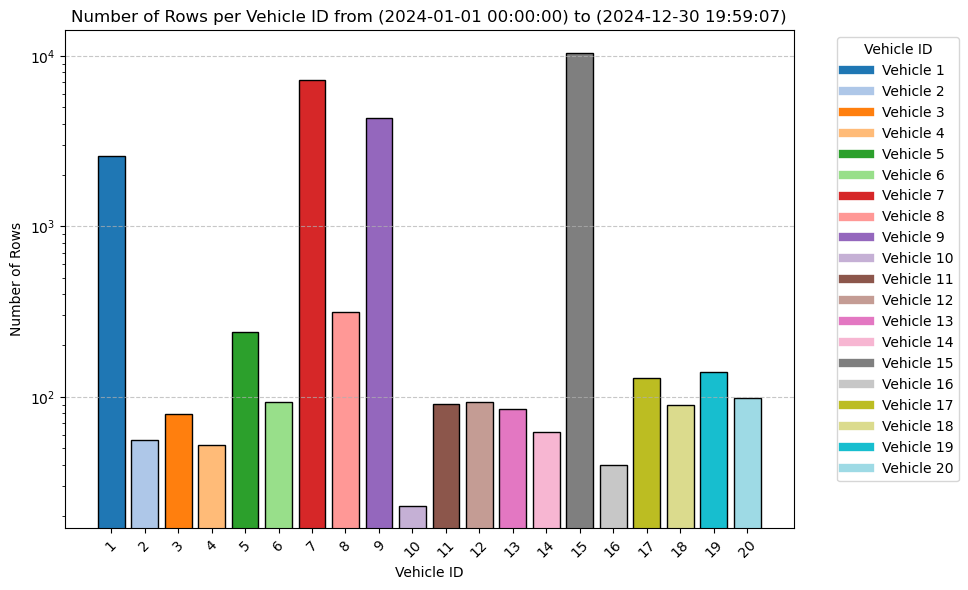

In [9]:
import matplotlib.cm as cm

# Collect unique vehicle IDs and the number of rows for each vehicle
unique_veh_ids = []
vehicle_rows = []

# Iterate over the list of all merged DataFrames
for individual_df in ALL_merged_dfsS:
    if not individual_df.empty:
        unique_veh_ids.append(individual_df['vehicleId'].values[0])  # Extract the vehicle ID
        vehicle_rows.append(len(individual_df))  # Count the number of rows in the DataFrame

# Debugging: Print the number of rows for each vehicle
for vehicle_id, rows in zip(unique_veh_ids, vehicle_rows):
    print(f"Vehicle ID {vehicle_id}: {rows} rows")

# Generate a colormap
num_vehicles = len(unique_veh_ids)
colors = cm.get_cmap('tab20', num_vehicles)(range(num_vehicles))  # Generate distinct colors for each vehicle

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_veh_ids, vehicle_rows, color=colors, edgecolor='black')  # Assign colors to bars

# Add a legend for the bar colors
legend_handles = [plt.Line2D([0], [0], color=color, lw=6, label=f'Vehicle {vehicle_id}') 
                  for color, vehicle_id in zip(colors, unique_veh_ids)]
plt.legend(handles=legend_handles, title="Vehicle ID", bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize plot
plt.xlabel('Vehicle ID')
plt.ylabel('Number of Rows')
plt.title(f'Number of Rows per Vehicle ID from ({PARAMETERS["snapshot_api"]["startDate"]}) to ({PARAMETERS["snapshot_api"]["endDate"]})')
plt.xticks(unique_veh_ids, rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set a logarithmic scale for better visualization of large variations
plt.yscale("log")

# Show the plot
plt.show()


In [10]:
merged_dfs.dtypes
print(merged_dfs)
print(merged_dfs['dateStored'].dtype)

       vehicleId        lat        lng     dateStored  velocity  odometer  \
0              1  38.034458  23.748177  1716382625000       0.0       0.0   
1              1  38.034598  23.748143  1716383081000       6.0       0.0   
2              1  38.034633  23.748132  1716383105000       0.0       0.0   
3              1  38.034667  23.748163  1716383333000       0.0       0.0   
4              1  38.034713  23.748122  1716383724000       8.0       0.0   
...          ...        ...        ...            ...       ...       ...   
26247         20  38.034748  23.746115  1716389383000      39.0       0.0   
26248         20  38.034988  23.745633  1716389387000      34.0       0.0   
26249         20  38.035463  23.745138  1716389388000      33.0       0.0   
26250         20  38.035783  23.744812  1716389389000      31.0       0.0   
26251         20  38.036093  23.744623  1716389390000      28.0       0.0   

       engineVoltage  
0                0.0  
1                0.0  
2     

2) Create 2 columns for datetime readable for Humans and for time alone


In [11]:
# Convert the 'dateStored' column to datetime format
merged_dfs['dateStoredHuman']           = merged_dfs['dateStored'].apply(lambda x: datetime.fromtimestamp(x / 1000))
merged_dfs['dateOnlyStoredHuman']       = merged_dfs['dateStoredHuman'].dt.date  # Extract the date only
merged_dfs['timeOnly']                  = merged_dfs['dateStoredHuman'].dt.time  # Extract the time only

# Sort the DataFrame by 'dateStored' in ascending order
# merged_dfs                              = merged_dfs.sort_values(by='dateStored', ascending=True)

# Extract columns of interest
lat_clmn                                = merged_dfs['lat']
long_clmn                               = merged_dfs['lng']
date_stored                             = merged_dfs['dateStored']

#! Drop temp columns
merged_dfs = merged_dfs.drop(columns=['dateStoredHuman'])



print(merged_dfs.head())

   vehicleId        lat        lng     dateStored  velocity  odometer  \
0          1  38.034458  23.748177  1716382625000       0.0       0.0   
1          1  38.034598  23.748143  1716383081000       6.0       0.0   
2          1  38.034633  23.748132  1716383105000       0.0       0.0   
3          1  38.034667  23.748163  1716383333000       0.0       0.0   
4          1  38.034713  23.748122  1716383724000       8.0       0.0   

   engineVoltage dateOnlyStoredHuman  timeOnly  
0            0.0          2024-05-22  15:57:05  
1            0.0          2024-05-22  16:04:41  
2            0.0          2024-05-22  16:05:05  
3            0.0          2024-05-22  16:08:53  
4            0.0          2024-05-22  16:15:24  


In [12]:
merged_dfs.dtypes
print(merged_dfs)
print(merged_dfs['dateStored'].dtype)

       vehicleId        lat        lng     dateStored  velocity  odometer  \
0              1  38.034458  23.748177  1716382625000       0.0       0.0   
1              1  38.034598  23.748143  1716383081000       6.0       0.0   
2              1  38.034633  23.748132  1716383105000       0.0       0.0   
3              1  38.034667  23.748163  1716383333000       0.0       0.0   
4              1  38.034713  23.748122  1716383724000       8.0       0.0   
...          ...        ...        ...            ...       ...       ...   
26247         20  38.034748  23.746115  1716389383000      39.0       0.0   
26248         20  38.034988  23.745633  1716389387000      34.0       0.0   
26249         20  38.035463  23.745138  1716389388000      33.0       0.0   
26250         20  38.035783  23.744812  1716389389000      31.0       0.0   
26251         20  38.036093  23.744623  1716389390000      28.0       0.0   

       engineVoltage dateOnlyStoredHuman  timeOnly  
0                0.0  

Plot all trips of all vehicles

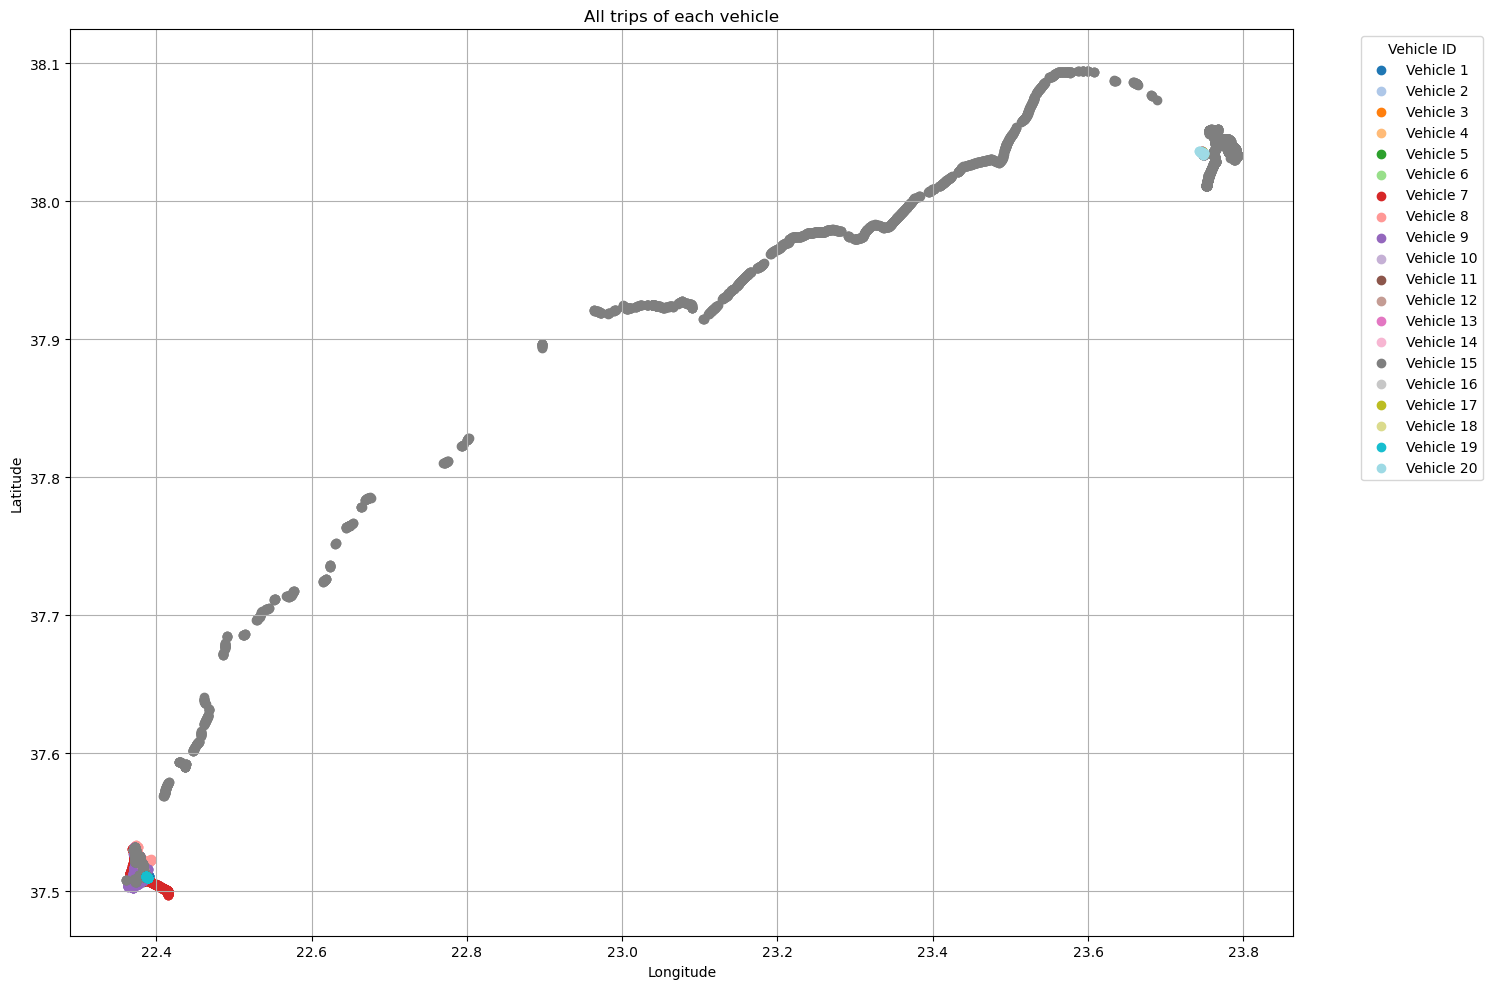

In [13]:
# Generate a list of unique colors
vehicle_ids = [df['vehicleId'].iloc[0] for df in ALL_merged_dfsS if 'vehicleId' in df.columns]
num_vehicles = len(vehicle_ids)
colors = cm.get_cmap('tab20', num_vehicles)  # Choose a colormap with sufficient colors

# Plot the data
plt.figure(figsize=(15, 10))
plt.title('All trips of each vehicle')

# Iterate through the DataFrame list and assign colors based on vehicle ID
for i, _tmp_merged_dfs in enumerate(ALL_merged_dfsS):
    if 'vehicleId' in _tmp_merged_dfs.columns:
        vehicle_id = _tmp_merged_dfs['vehicleId'].iloc[0]  # Assuming each DataFrame corresponds to one vehicle
        color = colors(i)
        plt.scatter(_tmp_merged_dfs['lng'], _tmp_merged_dfs['lat'], label=f'Vehicle {vehicle_id}', color=color)

# Plot formatting
plt.xlabel('Longitude')  # Fixed typo
plt.ylabel('Latitude')
plt.grid()
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend outside the plot
plt.tight_layout()
plt.show()


In [14]:
merged_dfs.dtypes
print(merged_dfs)
print(merged_dfs['dateStored'].dtype)

       vehicleId        lat        lng     dateStored  velocity  odometer  \
0              1  38.034458  23.748177  1716382625000       0.0       0.0   
1              1  38.034598  23.748143  1716383081000       6.0       0.0   
2              1  38.034633  23.748132  1716383105000       0.0       0.0   
3              1  38.034667  23.748163  1716383333000       0.0       0.0   
4              1  38.034713  23.748122  1716383724000       8.0       0.0   
...          ...        ...        ...            ...       ...       ...   
26247         20  38.034748  23.746115  1716389383000      39.0       0.0   
26248         20  38.034988  23.745633  1716389387000      34.0       0.0   
26249         20  38.035463  23.745138  1716389388000      33.0       0.0   
26250         20  38.035783  23.744812  1716389389000      31.0       0.0   
26251         20  38.036093  23.744623  1716389390000      28.0       0.0   

       engineVoltage dateOnlyStoredHuman  timeOnly  
0                0.0  

Plot velocity

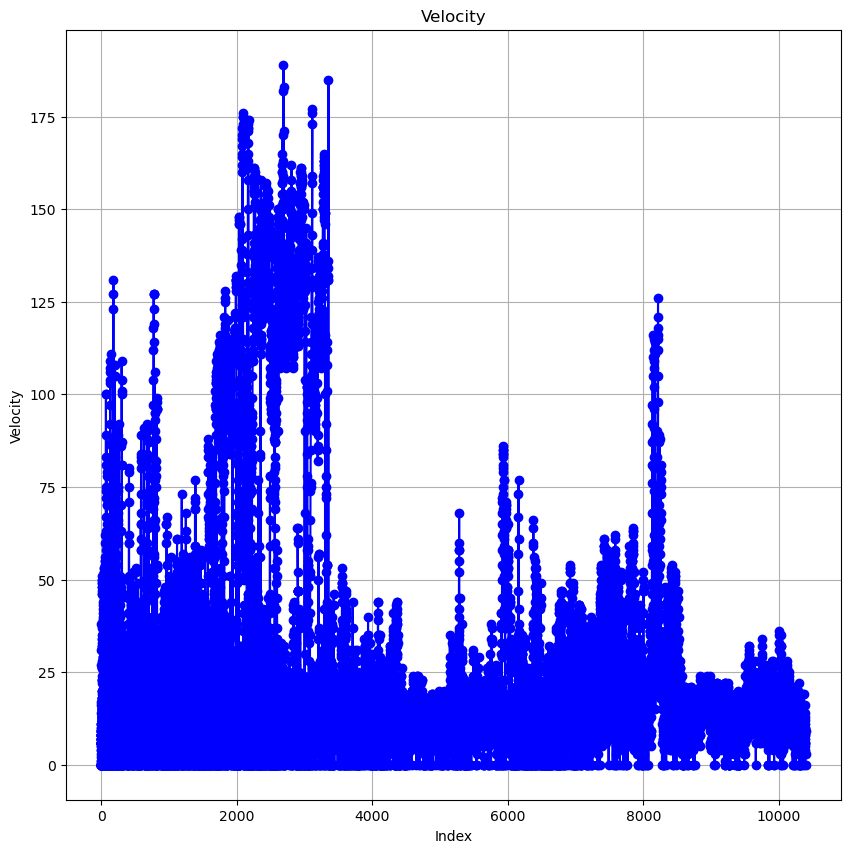

In [15]:
plt.figure(figsize=(10, 10))
plt.title('Velocity')

_tmp_merged_dfs = merged_dfs
for _tmp_merged_dfs in ALL_merged_dfsS:
    plt.xlabel('Index')
    plt.ylabel('Velocity')
    plt.plot(_tmp_merged_dfs['velocity'], marker='o', linestyle='-', color='b')
    plt.grid(True)

plt.show()


In [16]:
print(merged_dfs['velocity'].values.max())

189.0


- Calculate which the **30 degrees turns** on coordinatess
- Add <u>**orientation column for the 30 degrees turns</u>** to corresponding coordinates
- Plot the **30 degrees turns** vs velocities **before and after** making the turn

| Decimal Places | Latitude Precision (meters) | Longitude Precision (meters at Equator) |
|----------------|-----------------------------|-----------------------------------------|
| 1              | ~11,132 m                   | ~11,132 m                               |
| 2              | ~1,113 m                    | ~1,113 m                                |
| 3              | ~111.3 m                    | ~111.3 m                                |
| 4              | ~11.13 m                    | ~11.13 m                                |
| 5              | ~1.113 m                    | ~1.113 m                                |
| 6              | ~0.1113 m                   | ~0.1113 m                               |
| 7              | ~0.01113 m                  | ~0.01113 m                              |
| 8              | ~0.001113 m                 | ~0.001113 m                             |

In [17]:
def process_coordinates(merged_dfs):
    # Load the dataset into a GeoDataFrame
    gmerged_dfs = gpd.GeoDataFrame(merged_dfs, geometry=gpd.points_from_xy(merged_dfs['lng'], merged_dfs['lat']))

    # Function to calculate precision correspondences
    def calculate_precision_distances():
        precision_list = []
        for decimals in range(1, 9):  # For 1 to 8 decimals
            latitude_precision = 111_320 / (10**decimals)  # Latitude: meters
            longitude_precision = latitude_precision  # Assuming equator (lat = 0)
            precision_list.append((decimals, latitude_precision, longitude_precision))
        return precision_list

    # Calculate precision distances
    precisions = calculate_precision_distances()

    # Create a DataFrame for output
    precision_merged_dfs = pd.DataFrame(precisions, columns=['Decimal Places', 'Latitude Precision (m)', 'Longitude Precision (m)'])
    # print(precision_merged_dfs)

    # Function to calculate the bearing between two points
    def calculate_bearing(lat1, lon1, lat2, lon2):
        """
        Calculate the bearing between two points.
        Returns the bearing in degrees.
        """
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)

        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        bearing_degrees = (math.degrees(bearing) + 360) % 360  # Normalize to 0-360
        return bearing_degrees

    # Function to get orientation from bearing
    def get_orientation(bearing):
        """
        Convert a bearing in degrees to a cardinal direction.
        """
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        idx = round(bearing / 45) % 8  # Divide by 45 degrees for 8 cardinal directions
        return directions[idx]

    # Function to get the latest and next coordinate
    def get_latest_and_next_coordinates(gmerged_dfs):
        latest_coordinate = gmerged_dfs.iloc[-1]  # The last entry is the latest coordinate
        # print("Latest coordinate:", latest_coordinate)

        # Get next coordinates and calculate bearings
        next_coordinates = []
        for idx in range(len(gmerged_dfs) - 1):
            current_row = gmerged_dfs.iloc[idx]
            next_row = gmerged_dfs.iloc[idx + 1]
            bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
            orientation = get_orientation(bearing)
            next_coordinates.append((current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'], bearing, orientation))
        
        return latest_coordinate, next_coordinates

    # Get the latest and next coordinates
    latest_coordinate, next_coordinates = get_latest_and_next_coordinates(gmerged_dfs)

    # Print the results
    print("\nLatest Coordinate:")
    print(latest_coordinate[['lat', 'lng']])

    print("\nNext Coordinates with Orientation:")
    for coord in next_coordinates:
        print(f"Current: ({coord[0]}, {coord[1]}) -> Next: ({coord[2]}, {coord[3]}) | Bearing: {coord[4]:.2f}° | Orientation: {coord[5]}")

    return latest_coordinate, next_coordinates

def add_orientation_column(merged_dfs):
    # Function to calculate the bearing between two points
    def calculate_bearing(lat1, lon1, lat2, lon2):
        """
        Calculate the bearing between two points.
        Returns the bearing in degrees.
        """
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)

        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        bearing_degrees = (math.degrees(bearing) + 360) % 360  # Normalize to 0-360
        return bearing_degrees

    # Function to get orientation from bearing
    def get_orientation(bearing):
        """
        Convert a bearing in degrees to a cardinal direction.
        """
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        idx = round(bearing / 45) % 8  # Divide by 45 degrees for 8 cardinal directions
        return directions[idx]

    # Add a new column "orientation"
    orientations = []

    # Loop through the DataFrame to calculate the bearing and orientation for each pair of consecutive coordinates
    for idx in range(len(merged_dfs) - 1):
        current_row = merged_dfs.iloc[idx]
        next_row = merged_dfs.iloc[idx + 1]
        
        # Calculate the bearing
        bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
        
        # Get the orientation from the bearing
        orientation = get_orientation(bearing)
        
        # Append the orientation to the list
        orientations.append(orientation)

    # For the last row, we can either leave the orientation empty or set it as "" since it has no "next" coordinate
    orientations.append("")

    # Add the "orientation" column to the DataFrame
    merged_dfs['orientation'] = orientations

    # Return the updated DataFrame
    return merged_dfs



# Assuming 'merged_dfs' is already defined as a DataFrame with columns 'lat' and 'lng'
latest_coordinate, next_coordinates = process_coordinates(merged_dfs)

# Assuming 'merged_dfs' is already defined as a DataFrame with columns 'lat' and 'lng'
merged_dfs = add_orientation_column(merged_dfs)

# Check the updated DataFrame
print(Fore.YELLOW + F"Updated DataFrame" + Style.RESET_ALL)





Latest Coordinate:
lat    38.036093
lng    23.744623
Name: 26251, dtype: object

Next Coordinates with Orientation:
Current: (38.0344583, 23.7481766) -> Next: (38.0345983, 23.7481433) | Bearing: 349.39° | Orientation: North
Current: (38.0345983, 23.7481433) -> Next: (38.0346333, 23.7481316) | Bearing: 345.25° | Orientation: North
Current: (38.0346333, 23.7481316) -> Next: (38.0346666, 23.7481633) | Bearing: 36.86° | Orientation: Northeast
Current: (38.0346666, 23.7481633) -> Next: (38.0347133, 23.7481216) | Bearing: 324.88° | Orientation: Northwest
Current: (38.0347133, 23.7481216) -> Next: (38.03486, 23.7479766) | Bearing: 322.10° | Orientation: Northwest
Current: (38.03486, 23.7479766) -> Next: (38.034715, 23.748065) | Bearing: 154.35° | Orientation: Southeast
Current: (38.034715, 23.748065) -> Next: (38.0345849, 23.74824) | Bearing: 133.35° | Orientation: Southeast
Current: (38.0345849, 23.74824) -> Next: (38.0344583, 23.7484183) | Bearing: 132.03° | Orientation: Southeast
Current:

Plot <u>velocities, orientations</u> **on** <u>coordinates</u>>

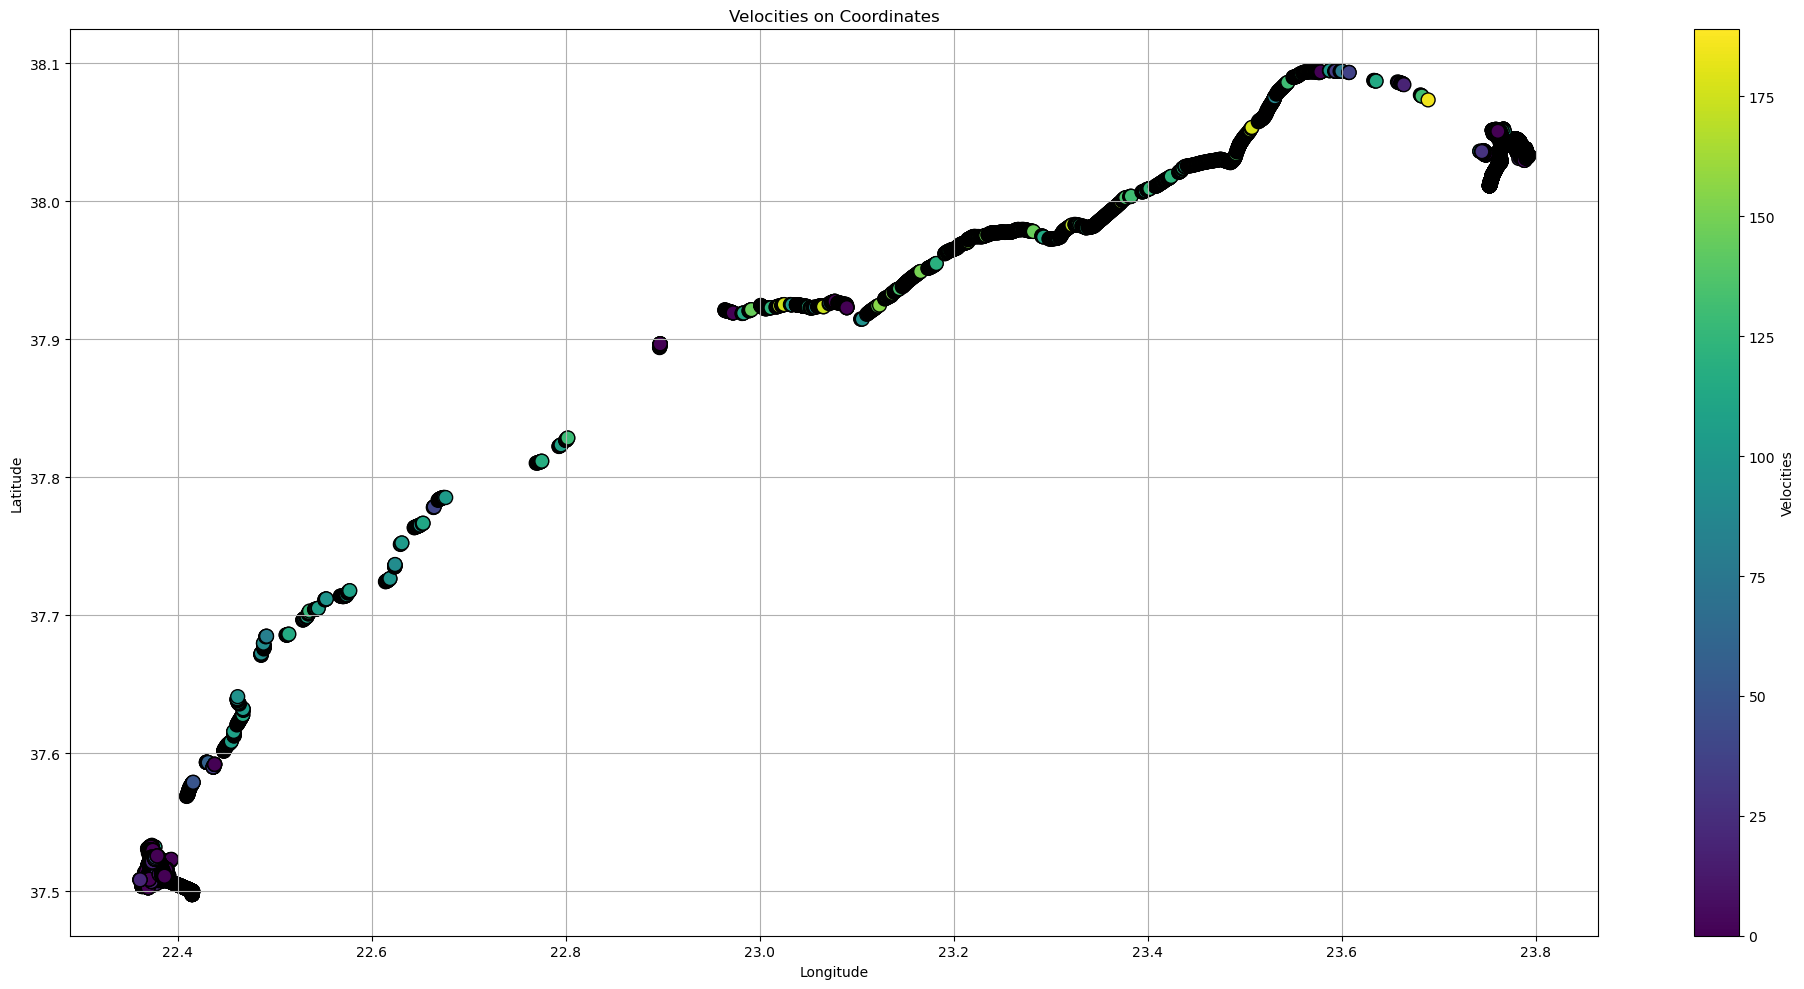

In [18]:
plt.figure(figsize=(20, 10))
plt.title('Velocities on Coordinates')
plt.xlabel('Longitude')  # Corrected label
plt.ylabel('Latitude')   # Corrected label
plt.grid()

# Plot the scatter plot with velocity as the color
scatter = plt.scatter(
    merged_dfs['lng'],  # Longitude on X-axis
    merged_dfs['lat'],  # Latitude on Y-axis
    c=merged_dfs['velocity'], 
    cmap='viridis', 
    s=100, 
    edgecolors='k'  # Ensure this matches the marker style
)

# Add color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Velocities')

plt.tight_layout()
plt.show()


In [19]:
import matplotlib.pyplot as plt

def get_velocity_in_area(df, startingLat, startingLng, endingLat, endingLng):
    """
    Get velocity data and vehicle IDs for rows within specified latitude and longitude bounds.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        startingLat (float): The starting latitude.
        startingLng (float): The starting longitude.
        endingLat (float): The ending latitude.
        endingLng (float): The ending longitude.

    Returns:
        pd.DataFrame: A DataFrame containing 'vehicleId' and 'velocity' within the specified area.
    """
    try:
        # Filter rows based on latitude and longitude ranges
        filtered_df = df[
            (df['lat'] >= min(startingLat, endingLat)) &
            (df['lat'] <= max(startingLat, endingLat)) &
            (df['lng'] >= min(startingLng, endingLng)) &
            (df['lng'] <= max(startingLng, endingLng))
        ]
        
        # Return the subset of DataFrame with 'vehicleId' and 'velocity' columns
        return filtered_df[['vehicleId', 'velocity']]

    except KeyError as e:
        print(f"Error: Missing required column: {e}")
        return pd.DataFrame(columns=['vehicleId', 'velocity'])
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return pd.DataFrame(columns=['vehicleId', 'velocity'])

# Example Usage
startingLat = 37.508745
startingLng = 22.38997
endingLat = 22.39001
endingLng = 37.513799

# Get filtered velocities
result = get_velocity_in_area(merged_dfs, startingLat, startingLng, endingLat, endingLng)


In [20]:
merged_dfs.dtypes

vehicleId                int64
lat                    float64
lng                    float64
dateStored               int64
velocity               float64
odometer               float64
engineVoltage          float64
dateOnlyStoredHuman     object
timeOnly                object
orientation             object
dtype: object

Extract 1 day and calculate the stops (**5 >= minutes and on the same coordinates**)

In [ ]:
def get_one_day(df):
    #! Convert timeOnly col to datetime
    df['timeOnly']      = pd.to_datetime(df['timeOnly'], format='%H:%M:%S').dt.time

    #! Get data from the day(s) with the most data
    id_counts           = df.groupby('vehicleId').size()
    max_count           = id_counts.max()
    ids_with_max_rows   = id_counts[id_counts == max_count].index.tolist()
    
    print(f"ID(s) with the most rows ({max_count} rows): {ids_with_max_rows}")
    
    
get_one_day(merged_dfs)


def calculate_stops(df, lat, lng, superkey):
    """
        Args:
            df (pd.DataFrame): The DataFrame containing the data.
            lat (float): The latitude to determine if is on the same point.
            lng (float): The Longitude to determine if is on the same point.
            superkey (str): The superkey to get the exact target line with data 
    """
    dt_start_time   = datetime.strptime("00:00:00", "%H:%M:%S").time()
    dt_end_time     = datetime.strptime("23:59:59", "%H:%M:%S").time()
    
        




last_time   = datetime.strptime(merged_dfs['timeOnly'][0], "%H:%M:%S").time()
lat         = merged_dfs['lat']
lng         = merged_dfs['lng']

superkey    = "" + merged_dfs['dateOnlyStoredHuman'] + "," + merged_dfs['timeOnly'] 
calculate_stops(merged_dfs, lat, lng, superkey)

ID(s) with the most rows (10395 rows): [15]
Data for ID 1:
      vehicleId        lat        lng     dateStored  velocity  odometer  \
0             1  38.034458  23.748177  1716382625000       0.0       0.0   
1             1  38.034598  23.748143  1716383081000       6.0       0.0   
2             1  38.034633  23.748132  1716383105000       0.0       0.0   
3             1  38.034667  23.748163  1716383333000       0.0       0.0   
4             1  38.034713  23.748122  1716383724000       8.0       0.0   
...         ...        ...        ...            ...       ...       ...   
2587          1  37.516487  22.376807  1734277068000       0.0       0.0   
2588          1  37.517128  22.378580  1734277069000      29.0       0.0   
2589          1  37.517092  22.378878  1734277072000      34.0       0.0   
2590          1  37.517138  22.379200  1734277079000      16.0       0.0   
2591          1  37.517150  22.379227  1734277098000       0.0       0.0   

      engineVoltage dateOnly

In order to finish, **update** the "all_vehicle_responses.csv" with the DataFrame

In [22]:
all_vehicles_data_path = "../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv"
merged_dfs.to_csv(all_vehicles_data_path, index=False)
print(f"DataFrame stored to {all_vehicles_data_path}")

DataFrame stored to ../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv
